<a href="https://colab.research.google.com/github/tushitgarg/HateSpeech/blob/master/Applying_Glove_on_twitter2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Glove Implementation

In [52]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import pymongo
from pymongo import MongoClient
import pprint as pp
! pip install normalise
import nltk
nltk.download('names')
nltk.download('brown')

import numpy as np
import multiprocessing as mp

import string
import spacy 
import en_core_web_sm
from nltk.tokenize import word_tokenize
from sklearn.base import TransformerMixin, BaseEstimator
from normalise import normalise
import re

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.main import main
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/main.py", line 13, in <module>
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/cli/autocompletion.py", line 11, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/cli/main_parser.py", line 7, in <module>
    from pip._internal.cli import cmdoptions
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/cli/cmdoptions.py", line 28, in <module>
    from pip._internal.models.target_python import TargetPython
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/models/target_python.py", line 4, in <module>
    from pip._internal.utils.misc import normalize_version_info
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/utils/misc.py", line 19, in <module>
    from pip._vendor import pk

In [0]:
from google.colab import drive
drive.mount('/content/drive')
cd '/content/drive/My Drive/minor2/twitter2/'

In [0]:
df1=pd.read_excel('twitter2_data.xlsx')

In [8]:
df1.head()

,_id,text,label
0,5e4ce1ac5ca387d4c86d31d9,RT @fairbairn77: I'm not sexist or anything bu...,1
1,5e4cebeb5ca387d4c86d4ec1,RT @colonelkickhead: Apparently walking a catw...,0
2,5e4d048f5ca387d4c86d8084,RT @athenahollow: @freebsdgirl He REALLY picke...,0
3,5e4ce2125ca387d4c86d32a6,@JohnJohnisKilla Call me sexist or whatever it...,1
4,5e4ceb135ca387d4c86d4cd1,I don't understand mean girls. And certainly n...,0


In [0]:
df1.drop(['level_0','index','Unnamed: 0'],axis=1,inplace=True)

In [0]:
def label(x):
    if(x=='sexism'):
        return 1
    else:
        return 0
for i in (df1.index):
    df1.iloc[i,4]=label(df1.iloc[i,4])
    

IndexError: ignored

In [0]:
from sklearn.utils import shuffle
df1 = shuffle(df1)

In [0]:
df1.reset_index(inplace=True,drop=True)

In [0]:
df1.drop(['level_0','index'],axis=1)

,_id,text,label
0,5e4ce1ac5ca387d4c86d31d9,RT @fairbairn77: I'm not sexist or anything bu...,1
1,5e4cebeb5ca387d4c86d4ec1,RT @colonelkickhead: Apparently walking a catw...,0
2,5e4d048f5ca387d4c86d8084,RT @athenahollow: @freebsdgirl He REALLY picke...,0
3,5e4ce2125ca387d4c86d32a6,@JohnJohnisKilla Call me sexist or whatever it...,1
4,5e4ceb135ca387d4c86d4cd1,I don't understand mean girls. And certainly n...,0
...,...,...,...
10836,5e4cdc055ca387d4c86d225a,.@feministlah @GreenWeiner Way way more than o...,1
10837,5e4d08a75ca387d4c86d8d44,"@j4cob @xor oh, good. was really worried.",0
10838,5e4cfb095ca387d4c86d6b63,/cast Spectral Guys\n\nParty time,0
10839,5e4d190d5ca387d4c86d9ebf,I'm not sexist but Happy Days &gt;&gt; Joanie ...,0


In [9]:
np.mean(df1['label'])

0.2634443317037174

In [0]:
df1['text'][2]

'RT @athenahollow: @freebsdgirl He REALLY picked the wrong women to go after me thinks.'

In [0]:
text=df1['text']
labels=df1['label']

In [0]:
nlp = en_core_web_sm.load()


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 variety="BrE",
                 user_abbrevs={},
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Text normalization
            2. Punctuation removal
            3. Stop words removal
            4. Lemmatization
        
        variety - format of date (AmE - american type, BrE - british format) 
        user_abbrevs - dict of user abbreviations mappings (from normalise package)
        n_jobs - parallel jobs to run
        """
        self.variety = variety
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()
        return X_copy.apply(self._preprocess_text)

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        text=self._clean_text(text)
        normalized_text = self._normalize(text)
        doc = nlp(normalized_text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

    def _normalize(self, text):
        # some issues in normalise package
        try:
            return ' '.join(normalise(text, variety=self.variety, user_abbrevs=self.user_abbrevs, verbose=False))
        except:
            return text

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]

    def _lemmatize(self, doc):
        return ' '.join([t.lemma_ for t in doc])
    
    
    def _clean_text(self,text):
      replace_1 = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
      replace_2 = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
      text=re.sub(r"http\S+", "", text)
      text = replace_1.sub("", text)
      text = replace_2.sub(" ", text)
      text=re.sub('\s+',' ',text)
      return text



In [12]:
%%time
text = TextPreprocessor(n_jobs=-1).transform(df1['text'])

CPU times: user 1min 24s, sys: 657 ms, total: 1min 25s
Wall time: 1min 25s


In [13]:
exdf=pd.DataFrame()
exdf['text']=["hello my \n is ./.,is tushit's \t @344$%% what are you D.R   running  doing?? please HELP!!"]
clean_ex = TextPreprocessor(n_jobs=-1).transform(exdf['text'])
print(clean_ex[0])

hello tushit @344$%% DR run HELP


In [15]:
from keras.preprocessing.text import Tokenizer
import numpy as np

max_words = 10000 # We will only consider the 10K most used words in this dataset

tokenizer = Tokenizer(num_words=max_words) # Setup
tokenizer.fit_on_texts(text) # Generate tokens by counting frequency
sequences = tokenizer.texts_to_sequences(text)

Using TensorFlow backend.


In [16]:
len(text)

10841

In [0]:
word_index = tokenizer.word_index


In [0]:
for w in word_index.keys():
    if(word_index[w]==921):
        print(w)

value


In [17]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 100 # Make all sequences 100 words long
data = pad_sequences(sequences, maxlen=maxlen)
print(data.shape) # We have 25K, 100 word sequences now

(10841, 100)


In [0]:
labels = np.asarray(labels)

# Shuffle data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

training_samples = 7000  # We will be training on 10K samples
#validation_samples = 4000  # We will be validating on 10000 samples

# Split data
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:]
y_val = labels[training_samples:]

In [0]:
! wget 'http://nlp.stanford.edu/data/wordvecs/glove.6B.zip'

--2020-02-20 09:57:34--  http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/wordvecs/glove.6B.zip [following]
--2020-02-20 09:57:34--  https://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip [following]
--2020-02-20 09:57:34--  http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182753 (822M) [applic

In [0]:
!unzip -q "/content/drive/My Drive/minor2/twitter2/glove.6B.zip"

In [19]:

#glove_dir = '../input/glove-global-vectors-for-word-representation' # This is the folder with the dataset

print('Loading word vectors')
embeddings_index = {} # We create a dictionary of word -> embedding
f = open('/content/drive/My Drive/minor2/twitter2/glove.6B.100d.txt','r') # Open file

# In the dataset, each line represents a new word embedding
# The line starts with the word and the embedding values follow
for line in tqdm(f):
    values = line.split()
    word = values[0] # The first value is the word, the rest are the values of the embedding
    values = np.asarray(values[1:], dtype='float32') # Load embedding
    embeddings_index[word] = values # Add embedding to our embedding dictionary
f.close()

print('Found %s word vectors.' % len(embeddings_index))

0it [00:00, ?it/s]

Loading word vectors


400001it [00:13, 30113.51it/s]

Found 400001 word vectors.


In [20]:
all_embs = np.stack(embeddings_index.values())
emb_mean = all_embs.mean() # Calculate mean
emb_std = all_embs.std() # Calculate standard deviation
emb_mean,emb_std

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(0.0044520576, 0.40815717)

In [0]:
embedding_dim = 100 # We now use larger embeddings
word_index = tokenizer.word_index
nb_words = min(max_words, len(word_index)) # How many words are there actually

# Create a random matrix with the same mean and std as the embeddings
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_dim))

# The vectors need to be in the same position as their index. 
# Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on

# Loop over all words in the word index
for word, i in word_index.items():
    # If we are above the amount of words we want to use we do nothing
    if i >= max_words: 
        continue
    # Get the embedding vector for the word
    embedding_vector = embeddings_index.get(word)
    # If there is an embedding vector, put it in the embedding matrix
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [0]:
df1.to_excel('twitter2_data.xlsx')

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history,name_of_fig):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    f=plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    f.savefig(name_of_fig, bbox_inches='tight', dpi=400)

In [23]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
embedding_dim = 100
model_conv = Sequential()
model_conv.add(Embedding(max_words, embedding_dim, input_length=maxlen, weights = [embedding_matrix], trainable = False))
#model_conv.add(Flatten())
model_conv.add(Dense(32, activation='relu'))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(100))
model_conv.add(Dense(1, activation='sigmoid'))
model_conv.summary()











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
dense_1 (Dense)              (None, 100, 32)           3232      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 64)            10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000

In [0]:
model_conv.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])



Train on 7000 samples, validate on 3841 samples
Epoch 1/5
7000/7000 [==============================] - 7s 998us/step - loss: 0.5181 - acc: 0.7701 - val_loss: 0.4543 - val_acc: 0.8131
Epoch 2/5
7000/7000 [==============================] - 5s 774us/step - loss: 0.4290 - acc: 0.8169 - val_loss: 0.4238 - val_acc: 0.8185
Epoch 3/5
7000/7000 [==============================] - 6s 834us/step - loss: 0.4053 - acc: 0.8303 - val_loss: 0.4084 - val_acc: 0.8303
Epoch 4/5
7000/7000 [==============================] - 6s 792us/step - loss: 0.3755 - acc: 0.8450 - val_loss: 0.3805 - val_acc: 0.8417
Epoch 5/5
7000/7000 [==============================] - 6s 822us/step - loss: 0.3516 - acc: 0.8539 - val_loss: 0.3732 - val_acc: 0.8474


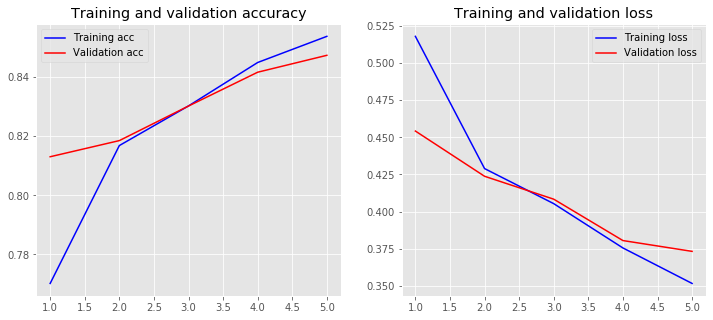

In [26]:
history = model_conv.fit(x_train, y_train,
                    epochs=5,
                    batch_size=64,
                    validation_data=(x_val, y_val))
plot_history(history,'/content/drive/My Drive/minor2/twitter2/accuracy and losses graphs.jpg')

# Word to vec Impementation

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import pymongo
from pymongo import MongoClient
import pprint as pp
! pip install normalise
import nltk
nltk.download('names')
nltk.download('brown')

import numpy as np
import multiprocessing as mp

import string
import spacy 
import en_core_web_sm
from nltk.tokenize import word_tokenize
from sklearn.base import TransformerMixin, BaseEstimator
from normalise import normalise
import re

     |████████████████████████████████| 15.7MB 206kB/s 
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.semi_supervised.label_propagation module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.semi_supervised. Anything that cannot be imported from sklearn.semi_supervised is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelPropagation from version 0.18 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd '/content/drive/My Drive/minor2/twitter2/'

/content/drive/My Drive/minor2/twitter2


In [0]:
df1=pd.read_excel('twitter2_data.xlsx')

In [5]:
df1.head()

,Unnamed: 0,level_0,index,_id,text,label
0,0,1912,1912,5e4ce1ac5ca387d4c86d31d9,RT @fairbairn77: I'm not sexist or anything bu...,1
1,1,3704,3704,5e4cebeb5ca387d4c86d4ec1,RT @colonelkickhead: Apparently walking a catw...,0
2,2,8201,8201,5e4d048f5ca387d4c86d8084,RT @athenahollow: @freebsdgirl He REALLY picke...,0
3,3,1990,1990,5e4ce2125ca387d4c86d32a6,@JohnJohnisKilla Call me sexist or whatever it...,1
4,4,3575,3575,5e4ceb135ca387d4c86d4cd1,I don't understand mean girls. And certainly n...,0


In [0]:
df1.drop(['level_0','index','Unnamed: 0'],axis=1,inplace=True)

In [0]:
text2=df1['text']
labels=df1['label']

In [0]:
nlp = en_core_web_sm.load()


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 variety="BrE",
                 user_abbrevs={},
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Text normalization
            2. Punctuation removal
            3. Stop words removal
            4. Lemmatization
        
        variety - format of date (AmE - american type, BrE - british format) 
        user_abbrevs - dict of user abbreviations mappings (from normalise package)
        n_jobs - parallel jobs to run
        """
        self.variety = variety
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()
        return X_copy.apply(self._preprocess_text)

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        text=self._clean_text(text)
        normalized_text = self._normalize(text)
        doc = nlp(normalized_text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

    def _normalize(self, text):
        # some issues in normalise package
        try:
            return ' '.join(normalise(text, variety=self.variety, user_abbrevs=self.user_abbrevs, verbose=False))
        except:
            return text

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]

    def _lemmatize(self, doc):
        return ' '.join([t.lemma_ for t in doc])
    
    
    def _clean_text(self,text):
      replace_1 = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
      replace_2 = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
      text=re.sub(r"http\S+", "", text)
      text = replace_1.sub("", text)
      text = replace_2.sub(" ", text)
      text=re.sub('\s+',' ',text)
      return text

In [9]:
%%time
text2 = TextPreprocessor(n_jobs=-1).transform(df1['text'])

CPU times: user 1min 29s, sys: 681 ms, total: 1min 29s
Wall time: 1min 29s


In [0]:
text2=text2.tolist()

In [0]:
text3=[]
for i in text2:
    lst=i.split()
    text3.append(lst)

In [12]:
len(text3)

10841

In [13]:
from gensim.models import Word2Vec
model_word2vec = Word2Vec(text3, size=100, window=5, min_count=5, workers=4,sg=0)
words = list(model_word2vec.wv.vocab)
print('Vocabulary size:', len(words))

Vocabulary size: 2538


In [14]:
model_word2vec.wv.save_word2vec_format('/content/drive/My Drive/minor2/twitter2/trained_word2vec.txt',binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [15]:
embeddings_index={}
f= open('/content/drive/My Drive/minor2/twitter2/trained_word2vec.txt',encoding='utf-8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.array(values[1:])
  embeddings_index[word]=coefs
f.close

<function TextIOWrapper.close>

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(text3)
sequences = tokenizer_obj.texts_to_sequences(text3)
max_length = max([len(s.split()) for s in text2])
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.',len(word_index))

tweets_pad = pad_sequences(sequences,maxlen=max_length)
sentiment = df1['label']
print('shape of tweets',tweets_pad.shape)
print('shape of sentiment',sentiment.shape)

Using TensorFlow backend.


Found %s unique tokens. 14886
shape of tweets (10841, 28)
shape of sentiment (10841,)


In [0]:
df3=pd.concat([pd.DataFrame(text2),pd.DataFrame(tweets_pad)],axis=1)

In [18]:
df3.head()

,0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,rt @fairbairn77 be sexist butno be hear female...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4154,4,5,4155,4,87,28,4156,91,3170,11
1,RT @colonelkickhead apparently walk catwalk in...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,714,829,210,830,592,474,1026,4157,16,8,210,1
2,RT @athenahollow @freebsdgirl pick wrong woman...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,643,53,489,128,7,10
3,@johnjohniskilla sexist s big difference 2 guy...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6361,5,9,106,431,74,64,13,374,952,752
4,not understand mean girl certainly mean girl A...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,202,55,13,1485,55,13,1664,1665,1,32


In [0]:
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words,100))

for word , i in word_index.items():
  if i > num_words:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i]=embedding_vector

In [20]:
print(num_words)

14887


In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

model = Sequential()
embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_length,
                            trainable=False)
model.add(embedding_layer)
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
#model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 100)           1488700   
_________________________________________________________________
dense_1 (Dense)              (None, 28, 32)            3232      
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 64)            10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 64)             0         
____________________________________

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_testing ,y_train, y_testing = train_test_split(df3, sentiment, test_size = 0.60, random_state = 1)

In [0]:
X_test, X_val ,y_test, y_val = train_test_split(X_testing, y_testing, test_size = 0.50, random_state = 0)

In [24]:
print('Training.....')
history=model.fit(X_train.iloc[:,1:], y_train, batch_size=32,epochs=10,validation_data=(X_val.iloc[:,1:],y_val),verbose=True)

Training.....


ValueError: ignored

In [48]:
loss, accuracy = model.evaluate(X_test.iloc[:,1:], y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

3252/3252 [==============================] - 1s 224us/step
Testing Accuracy:  0.8044


In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history,name_of_fig):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    f=plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    f.savefig(name_of_fig, bbox_inches='tight', dpi=400)

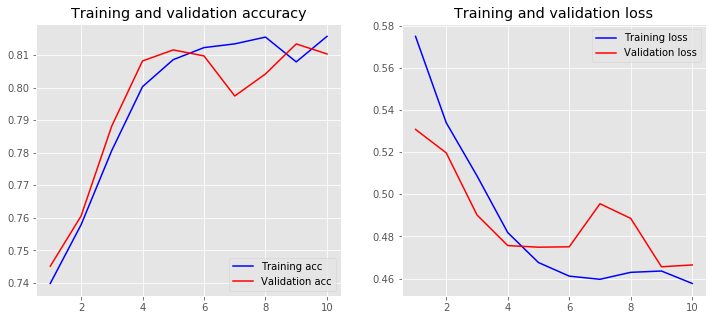

In [51]:
plot_history(history,'/content/drive/My Drive/minor2/twitter2/accuracy and losses graphs(word2vec).jpg')

# Fasttext

In [53]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import pymongo
from pymongo import MongoClient
import pprint as pp
! pip install normalise
import nltk
nltk.download('names')
nltk.download('brown')

import numpy as np
import multiprocessing as mp

import string
import spacy 
import en_core_web_sm
from nltk.tokenize import word_tokenize
from sklearn.base import TransformerMixin, BaseEstimator
from normalise import normalise
import re

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [0]:
df1=pd.read_excel('twitter2_data.xlsx')

In [0]:
df1.drop(['level_0','index','Unnamed: 0'],axis=1,inplace=True)

In [0]:
text4=df1['text']
labels=df1['label']

In [0]:
nlp = en_core_web_sm.load()


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 variety="BrE",
                 user_abbrevs={},
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Text normalization
            2. Punctuation removal
            3. Stop words removal
            4. Lemmatization
        
        variety - format of date (AmE - american type, BrE - british format) 
        user_abbrevs - dict of user abbreviations mappings (from normalise package)
        n_jobs - parallel jobs to run
        """
        self.variety = variety
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()
        return X_copy.apply(self._preprocess_text)

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        text=self._clean_text(text)
        normalized_text = self._normalize(text)
        doc = nlp(normalized_text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

    def _normalize(self, text):
        # some issues in normalise package
        try:
            return ' '.join(normalise(text, variety=self.variety, user_abbrevs=self.user_abbrevs, verbose=False))
        except:
            return text

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]

    def _lemmatize(self, doc):
        return ' '.join([t.lemma_ for t in doc])
    
    
    def _clean_text(self,text):
      replace_1 = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
      replace_2 = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
      text=re.sub(r"http\S+", "", text)
      text = replace_1.sub("", text)
      text = replace_2.sub(" ", text)
      text=re.sub('\s+',' ',text)
      return text

In [58]:
%%time
text4 = TextPreprocessor(n_jobs=-1).transform(df1['text'])

CPU times: user 1min 49s, sys: 653 ms, total: 1min 49s
Wall time: 1min 49s


In [0]:
text4=text4.tolist()

In [0]:
text5=[]
for i in text4:
    lst=i.split()
    text5.append(lst)

In [61]:
from gensim.models import FastText
model_fasttext = FastText(text5, size=100, window=5, min_count=5, workers=4,sg=0)
words = list(model_fasttext.wv.vocab)
print('Vocabulary size:', len(words))

Vocabulary size: 2538


In [68]:
model_fasttext.wv.save_word2vec_format('/content/drive/My Drive/minor2/twitter2/trained_fasttext.txt',binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [69]:
embeddings_index={}
f= open('/content/drive/My Drive/minor2/twitter2/trained_fasttext.txt',encoding='utf-8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.array(values[1:])
  embeddings_index[word]=coefs
f.close

<function TextIOWrapper.close>

In [70]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(text5)
sequences = tokenizer_obj.texts_to_sequences(text5)
max_length = max([len(s.split()) for s in text4])
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.',len(word_index))

tweets_pad = pad_sequences(sequences,maxlen=max_length)
sentiment = df1['label']
print('shape of tweets',tweets_pad.shape)
print('shape of sentiment',sentiment.shape)

Found %s unique tokens. 14886
shape of tweets (10841, 28)
shape of sentiment (10841,)


In [0]:
df4=pd.concat([pd.DataFrame(text4),pd.DataFrame(tweets_pad)],axis=1)

In [0]:
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words,100))

for word , i in word_index.items():
  if i > num_words:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i]=embedding_vector

In [73]:
model_fasttext.wv.most_similar("antigun")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('cross', 0.999660849571228),
 ('evening', 0.9996502995491028),
 ('open', 0.9996476769447327),
 ('fish', 0.9996459484100342),
 ('@samred', 0.9996451139450073),
 ('bite', 0.9996450543403625),
 ('advice', 0.9996446371078491),
 ('cringe', 0.9996445178985596),
 ('willing', 0.9996441602706909),
 ('wing', 0.9996434450149536)]

In [74]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

model = Sequential()
embedding_layer = Embedding(num_words,
                            100,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_length,
                            trainable=False)
model.add(embedding_layer)
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 28, 100)           1488700   
_________________________________________________________________
dense_3 (Dense)              (None, 28, 32)            3232      
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24, 64)            10304     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_testing ,y_train, y_testing = train_test_split(df4, sentiment, test_size = 0.60, random_state = 1)

In [0]:
X_test, X_val ,y_test, y_val = train_test_split(X_testing, y_testing, test_size = 0.50, random_state = 0)

In [77]:
print('Training.....')
history=model.fit(X_train.iloc[:,1:], y_train, batch_size=32,epochs=10,validation_data=(X_val.iloc[:,1:],y_val),verbose=True)

Training.....
Train on 4336 samples, validate on 3253 samples
Epoch 1/10
4336/4336 [==============================] - 5s 1ms/step - loss: 0.5812 - acc: 0.7399 - val_loss: 0.5371 - val_acc: 0.7412
Epoch 2/10
4336/4336 [==============================] - 4s 824us/step - loss: 0.5319 - acc: 0.7555 - val_loss: 0.5253 - val_acc: 0.7575
Epoch 3/10
4336/4336 [==============================] - 3s 800us/step - loss: 0.5228 - acc: 0.7620 - val_loss: 0.5309 - val_acc: 0.7488
Epoch 4/10
4336/4336 [==============================] - 4s 844us/step - loss: 0.5189 - acc: 0.7652 - val_loss: 0.5232 - val_acc: 0.7639
Epoch 5/10
4336/4336 [==============================] - 4s 872us/step - loss: 0.5108 - acc: 0.7744 - val_loss: 0.5220 - val_acc: 0.7599
Epoch 6/10
4336/4336 [==============================] - 3s 803us/step - loss: 0.5066 - acc: 0.7837 - val_loss: 0.5221 - val_acc: 0.7787
Epoch 7/10
4336/4336 [==============================] - 4s 851us/step - loss: 0.5014 - acc: 0.7853 - val_loss: 0.5016 - val_

In [78]:
loss, accuracy = model.evaluate(X_test.iloc[:,1:], y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

3252/3252 [==============================] - 1s 253us/step
Testing Accuracy:  0.8103


In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history,name_of_fig):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    f=plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    f.savefig(name_of_fig, bbox_inches='tight', dpi=400)

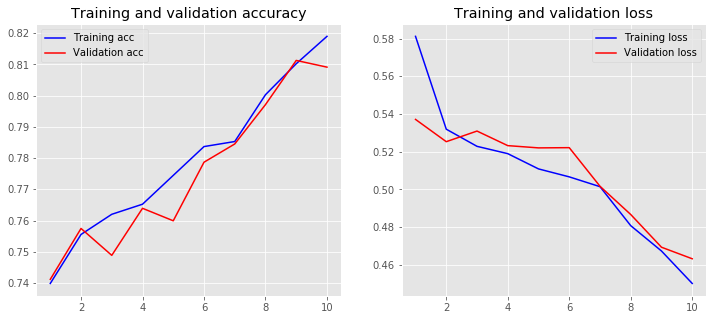

In [80]:
plot_history(history,'/content/drive/My Drive/minor2/twitter2/accuracy and losses graphs(fasttext).jpg')